<a href="https://colab.research.google.com/github/euniceky/YogaPoseDetection/blob/master/tf_feat_ex_sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function, division
import os
import time
import copy
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, InceptionResNetV2, InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
import math

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
print(tf.__version__)

2.1.0-rc1


# Model introduction

In [0]:
# Built from scratch
model_scratch = tf.keras.Sequential([
  Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
  Conv2D(64, (3, 3), activation='relu', padding='same'),
  MaxPooling2D(pool_size=(2, 2)),
  #Dropout(0.25),

  Conv2D(128, (3, 3), activation='relu'),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  #Dropout(0.25),
  
  GlobalAveragePooling2D(),
  Dense(4, activation='softmax')
])

model_scratch.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 108, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0

In [0]:
# Built from scratch
model_scratch2 = tf.keras.Sequential([
  Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
  Conv2D(64, (3, 3), activation='relu', padding='same'),
  MaxPooling2D(pool_size=(2, 2)),
  #Dropout(0.25),

  Conv2D(128, (3, 3), activation='relu'),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  #Dropout(0.25),
  
  Dense(1024),
  Dense(1024),
  GlobalAveragePooling2D(),
  Dense(4, activation='softmax')
])

model_scratch2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_309 (Conv2D)          (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_310 (Conv2D)          (None, 224, 224, 64)      18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_311 (Conv2D)          (None, 110, 110, 128)     73856     
_________________________________________________________________
conv2d_312 (Conv2D)          (None, 108, 108, 128)     147584    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 54, 54, 128)       0         
_________________________________________________________________
dense_12 (Dense)             (None, 54, 54, 1024)     

In [0]:
base_model_in = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(299,299,3))
base_model_res = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model_inv3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
base_model_in.trainable = False
base_model_res.trainable = False
base_model_inv3.trainable = False
#for layer in base_model2.layers[:]:
#   layer.trainable = True

In [0]:
# Add the output layers
model_in = tf.keras.Sequential([base_model_in, 
                              GlobalAveragePooling2D(),
                              Dense(4, activation='softmax')])
 
model_res = tf.keras.Sequential([base_model_res, 
                              GlobalAveragePooling2D(),
                              Dense(4, activation='softmax')])


model_inv3 = tf.keras.Sequential([base_model_inv3, 
                              GlobalAveragePooling2D(),
                              Dense(4, activation='softmax')])

# Data preprocessing, image augmentation

In [0]:
# Creating objects for image augmentations
train_datagen = ImageDataGenerator(preprocessing_function= preprocess_input,
                                   rescale = 1./255,
                                   rotation_range = 30,
                                   horizontal_flip = True,
                                   featurewise_center = True, 
                                   featurewise_std_normalization = True)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale = 1./255, featurewise_center=True,
                                        featurewise_std_normalization=True)
 
test_datagen = ImageDataGenerator(preprocessing_function= preprocess_input,
                                  rescale = 1./255, featurewise_center=True,
                                        featurewise_std_normalization=True)

# Creating datasets
training_set = train_datagen.flow_from_directory('/content/drive/My Drive/train',
                                                 target_size = (224, 224),
                                                 batch_size = 8,
                                                 class_mode = 'categorical', shuffle=True)
val_set = val_datagen.flow_from_directory('/content/drive/My Drive/val',
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/My Drive/test',
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            class_mode = 'categorical')
 

Found 824 images belonging to 4 classes.
Found 231 images belonging to 4 classes.
Found 117 images belonging to 4 classes.


# Training Models

### 1. From scratch model without dropouts


In [0]:
# Decaying learning rate
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.1
   epochs_drop = 5.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((epoch-1)/epochs_drop))
   return lrate
callback = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [0]:
# Compile, Train, and Test
model_scratch.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics = ['accuracy'])
model_scratch.fit(training_set, epochs = 20, validation_data = val_set, callbacks=[callback], verbose=1)

model_scratch.save_weights("model_scratch.h5")
# Test the model 
model_scratch.evaluate(test_set)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 103 steps, validate for 29 steps
Epoch 1/20
103/103 [==============================] - 221s 2s/step - loss: 1.3595 - accuracy: 0.3629 - val_loss: 1.3531 - val_accuracy: 0.3723
Epoch 2/20
103/103 [==============================] - 24s 233ms/step - loss: 1.3529 - accuracy: 0.3677 - val_loss: 1.3467 - val_accuracy: 0.3723
Epoch 3/20
103/103 [==============================] - 24s 232ms/step - loss: 1.3489 - accuracy: 0.3677 - val_loss: 1.3454 - val_accuracy: 0.3723
Epoch 4/20
103/103 [==============================] - 24s 235ms/step - loss: 1.3478 - accuracy: 0.3677 - val_loss: 1.3452 - val_accuracy: 0.3723
Epoch 5/20
103/103 [==============================] - 24s 234ms/step - loss: 1.3476 - accuracy: 0.3677 - val_loss: 1.3453 - val_accuracy: 0.3723
Epoch 6/20
103/103 [==============================] - 24s 232ms/step - loss: 1.3469 - accuracy: 0.3677 - val_loss: 1.3455 - val_accuracy: 0.3723
Epoch 7/20
103/103 [===================

[1.3449068705240885, 0.36752138]

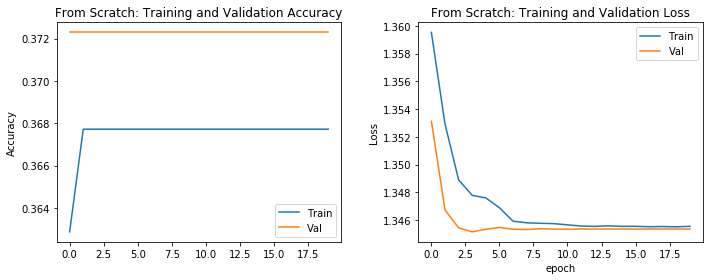

In [0]:
acc = model_scratch.history.history['accuracy']
val_acc = model_scratch.history.history['val_accuracy']

loss = model_scratch.history.history['loss']
val_loss = model_scratch.history.history['val_loss']

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([0,max(plt.ylim())])
plt.title('From Scratch: Training and Validation Accuracy')

plt.subplot(1,2, 2)
plt.plot(loss, label='Train')
plt.plot(val_loss, label='Val')
plt.legend(loc='upper right')
plt.ylabel('Loss')
#plt.ylim([0,5.0])
plt.title('From Scratch: Training and Validation Loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

### 1.5 Model from scratch, with dense layers, without dropouts

In [0]:
# Compile, Train, and Test
model_scratch2.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics = ['accuracy'])
model_scratch2.fit(training_set, epochs = 20, validation_data = val_set, callbacks=[callback], verbose=1)

model_scratch2.save_weights("model_scratch2.h5")
# Test the model 
model_scratch2.evaluate(test_set)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 103 steps, validate for 29 steps
Epoch 1/20
103/103 [==============================] - 26s 253ms/step - loss: 1.3550 - accuracy: 0.3568 - val_loss: 1.3515 - val_accuracy: 0.3723
Epoch 2/20
103/103 [==============================] - 26s 252ms/step - loss: 1.3533 - accuracy: 0.3677 - val_loss: 1.3460 - val_accuracy: 0.3723
Epoch 3/20
103/103 [==============================] - 26s 248ms/step - loss: 1.3492 - accuracy: 0.3677 - val_loss: 1.3446 - val_accuracy: 0.3723
Epoch 4/20
103/103 [==============================] - 26s 250ms/step - loss: 1.3484 - accuracy: 0.3677 - val_loss: 1.3446 - val_accuracy: 0.3723
Epoch 5/20
103/103 [==============================] - 26s 249ms/step - loss: 1.3483 - accuracy: 0.3677 - val_loss: 1.3449 - val_accuracy: 0.3723
Epoch 6/20
103/103 [==============================] - 26s 250ms/step - loss: 1.3479 - accuracy: 0.3677 - val_loss: 1.3449 - val_accuracy: 0.3723
Epoch 7/20
103/103 [=================

[1.3452404419581094, 0.36752138]

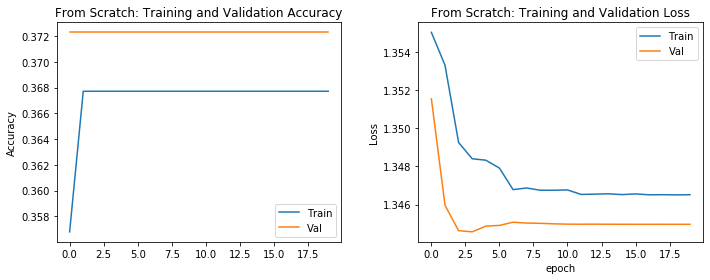

In [0]:
acc = model_scratch2.history.history['accuracy']
val_acc = model_scratch2.history.history['val_accuracy']

loss = model_scratch2.history.history['loss']
val_loss = model_scratch2.history.history['val_loss']

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([0,max(plt.ylim())])
plt.title('From Scratch: Training and Validation Accuracy')

plt.subplot(1,2, 2)
plt.plot(loss, label='Train')
plt.plot(val_loss, label='Val')
plt.legend(loc='upper right')
plt.ylabel('Loss')
#plt.ylim([0,5.0])
plt.title('From Scratch: Training and Validation Loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

### 2. InceptionResnet: feature extraction


In [0]:
# Compile, Train, and Test
model_in.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics = ['accuracy'])
model_in.fit(training_set, epochs = 20, validation_data = val_set, callbacks=[callback], verbose=1)
# Save the model 
model_in.save_weights("model_in.h5")

model_in.evaluate(test_set)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 103 steps, validate for 29 steps
Epoch 1/20
103/103 [==============================] - 36s 351ms/step - loss: 1.4568 - accuracy: 0.4345 - val_loss: 2.5622 - val_accuracy: 0.5108
Epoch 2/20
103/103 [==============================] - 25s 243ms/step - loss: 1.0734 - accuracy: 0.6359 - val_loss: 0.9930 - val_accuracy: 0.6580
Epoch 3/20
103/103 [==============================] - 25s 246ms/step - loss: 0.7542 - accuracy: 0.6857 - val_loss: 0.9501 - val_accuracy: 0.6407
Epoch 4/20
103/103 [==============================] - 26s 248ms/step - loss: 0.7613 - accuracy: 0.6978 - val_loss: 0.9930 - val_accuracy: 0.6190
Epoch 5/20
103/103 [==============================] - 25s 244ms/step - loss: 0.7319 - accuracy: 0.7075 - val_loss: 1.0466 - val_accuracy: 0.6061
Epoch 6/20
103/103 [==============================] - 25s 245ms/step - loss: 0.7303 - accuracy: 0.6990 - val_loss: 1.0779 - val_accuracy: 0.6061
Epoch 7/20
103/103 [=================

[0.7684102863073349, 0.6923077]

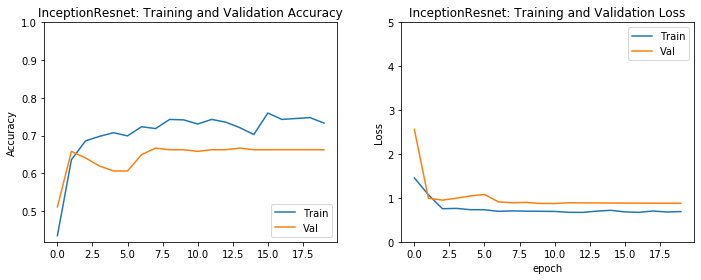

In [0]:
acc = model_in.history.history['accuracy']
val_acc = model_in.history.history['val_accuracy']

loss = model_in.history.history['loss']
val_loss = model_in.history.history['val_loss']

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('InceptionResnet: Training and Validation Accuracy')

plt.subplot(1,2, 2)
plt.plot(loss, label='Train')
plt.plot(val_loss, label='Val')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,5.0])
plt.title('InceptionResnet: Training and Validation Loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

### 3. Resnet50: feature extraction

In [0]:
# Compile, Train, and Test
model_res.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics = ['accuracy'])
model_res.fit(training_set, epochs = 20, validation_data = val_set, callbacks=[callback], verbose=1)
 
model_res.save_weights("model_res.h5")

# Test the model 
model_res.evaluate(test_set)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 103 steps, validate for 29 steps
Epoch 1/20
103/103 [==============================] - 27s 260ms/step - loss: 2.2883 - accuracy: 0.5218 - val_loss: 3.7149 - val_accuracy: 0.3723
Epoch 2/20
103/103 [==============================] - 24s 229ms/step - loss: 0.8275 - accuracy: 0.7803 - val_loss: 4.1892 - val_accuracy: 0.3723
Epoch 3/20
103/103 [==============================] - 23s 228ms/step - loss: 0.5743 - accuracy: 0.8289 - val_loss: 4.0000 - val_accuracy: 0.3723
Epoch 4/20
103/103 [==============================] - 24s 230ms/step - loss: 0.4507 - accuracy: 0.8519 - val_loss: 3.7043 - val_accuracy: 0.3723
Epoch 5/20
103/103 [==============================] - 23s 226ms/step - loss: 0.4395 - accuracy: 0.8762 - val_loss: 3.2319 - val_accuracy: 0.3723
Epoch 6/20
103/103 [==============================] - 24s 228ms/step - loss: 0.4309 - accuracy: 0.8592 - val_loss: 3.1567 - val_accuracy: 0.3723
Epoch 7/20
103/103 [=================

[3.1295172373453775, 0.36752138]

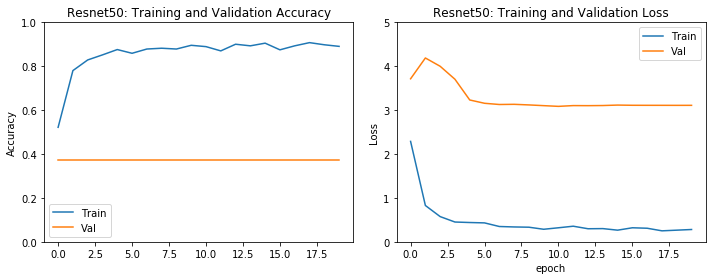

In [0]:
acc = model_res.history.history['accuracy']
val_acc = model_res.history.history['val_accuracy']

loss = model_res.history.history['loss']
val_loss = model_res.history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.ylabel('Accuracy')
plt.ylim([0,1.0])
plt.ylim([min(plt.ylim()),1])
plt.title('Resnet50: Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train')
plt.plot(val_loss, label='Val')
plt.legend()
plt.ylabel('Loss')
plt.ylim([0,5.0])
plt.title('Resnet50: Training and Validation Loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()


### 4: InceptionV3: feature extraction

In [0]:
# Compile, Train, and Test
model_inv3.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics = ['accuracy'])
model_inv3.fit(training_set, epochs = 20, validation_data = val_set, callbacks=[callback], verbose=1)
 
model_inv3.save_weights("model_inv3.h5")

# Test the model 
model_inv3.evaluate(test_set)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 103 steps, validate for 29 steps
Epoch 1/20
103/103 [==============================] - 28s 274ms/step - loss: 1.4272 - accuracy: 0.4248 - val_loss: 1.3102 - val_accuracy: 0.5628
Epoch 2/20
103/103 [==============================] - 24s 236ms/step - loss: 1.0713 - accuracy: 0.6226 - val_loss: 1.4469 - val_accuracy: 0.5281
Epoch 3/20
103/103 [==============================] - 24s 234ms/step - loss: 0.7714 - accuracy: 0.6881 - val_loss: 1.5255 - val_accuracy: 0.5411
Epoch 4/20
103/103 [==============================] - 24s 232ms/step - loss: 0.7387 - accuracy: 0.6990 - val_loss: 1.4306 - val_accuracy: 0.5584
Epoch 5/20
103/103 [==============================] - 24s 232ms/step - loss: 0.7426 - accuracy: 0.6845 - val_loss: 1.1716 - val_accuracy: 0.5974
Epoch 6/20
103/103 [==============================] - 25s 246ms/step - loss: 0.7276 - accuracy: 0.7124 - val_loss: 1.1056 - val_accuracy: 0.5887
Epoch 7/20
103/103 [=================

[1.3899903098742168, 0.5470086]

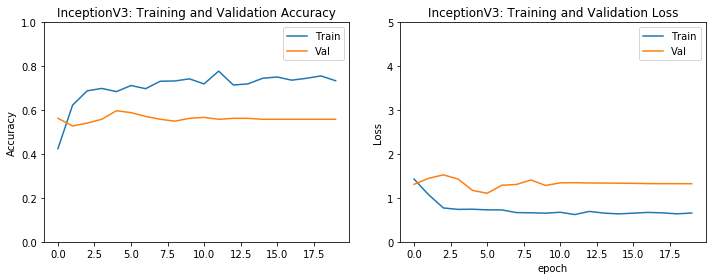

In [0]:
acc = model_inv3.history.history['accuracy']
val_acc = model_inv3.history.history['val_accuracy']

loss = model_inv3.history.history['loss']
val_loss = model_inv3.history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.ylabel('Accuracy')
plt.ylim([0,1.0])
plt.ylim([min(plt.ylim()),1])
plt.title('InceptionV3: Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train')
plt.plot(val_loss, label='Val')
plt.legend()
plt.ylabel('Loss')
plt.ylim([0,5.0])
plt.title('InceptionV3: Training and Validation Loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()
